## Bayesian estimation of vaccine effectiveness

Copyright 2020 Allen Downey

[MIT License](https://opensource.org/licenses/MIT)

In [ ]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from empiricaldist import Pmf

According to [this press release](https://www.pfizer.com/news/press-release/press-release-detail/pfizer-and-biontech-announce-vaccine-candidate-against)

> The first set of results from our Phase 3 COVID-19 vaccine trial provides the initial evidence of our vaccine’s ability to prevent COVID-19.

The press release includes the following details about the results

> The ... trial ... has enrolled 43,538 participants to date, 38,955 of whom have received a second dose of the vaccine candidate as of November 8, 2020.
>
>  ... the evaluable case count reached 94 and ... the case split between vaccinated individuals and those who received the placebo indicates a vaccine efficacy rate above 90%, at 7 days after the second dose.

The press release provides only a point estimate for the effectiveness of the vaccine, and it does not provide enough information to make a better estimate.

But with some guesswork, we can compute the posterior distribution of effectiveness, and use it to estimate the lower bound of the credible interval.

Since we don't know how many people are in each branch of the trial, I'll assume that it is approximately equal.

In [2]:
n_control = 38955 / 2
n_treatment = 38955 / 2

We know there were a total of 94 infections in the two branches.  Since the estimated effectiveness is 90%, I'll guess that there were 86 infections in the control branch and 8 in the treatment branch.

We can make a beta distribution that represents the posterior distribution of the infection rate in the control branch, starting with a uniform distribution.

In [3]:
from scipy.stats import beta

dist_control = beta(86+1, n_control+1)
dist_control.mean() * 100

0.4446602437964785

And here's the posterior distribution for the treatment branch.

In [4]:
dist_treatment = beta(8+1, n_treatment+1)
dist_treatment.mean() * 100

0.046183450930083386

The risk ratio is about 10:1, which is consistent with 90% effectiveness.

To compute the distribution of risk ratios, I'll make a discrete approximation to the two posterior distributions, using the `Pmf` object from `empiricaldist`:

In [5]:
def make_beta(dist):
    """PMF to approximate a beta distribution.
    
    dist: `beta` object
    
    returns: Pmf
    """
    qs = np.linspace(8e-6, 0.008, 1000)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

Here are the `Pmf` objects:

In [6]:
pmf_control = make_beta(dist_control)
pmf_treatment = make_beta(dist_treatment)

And here's what they look like:

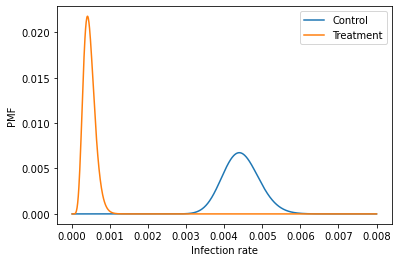

In [7]:
pmf_control.plot(label='Control')
pmf_treatment.plot(label='Treatment')

plt.xlabel('Infection rate')
plt.ylabel('PMF')
plt.legend();

Again, it looks like the infection rate is about 10 times higher in the control group.

We can use `div_dist` to compute the risk ratio.

In [8]:
pmf_ratio = pmf_treatment.div_dist(pmf_control)

Here's the CDF of the risk ratio.  I cut it off at 1 because higher values have very low probabilities; that is, we are pretty sure the treatment is effective.

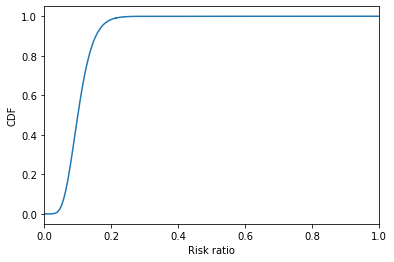

In [9]:
pmf_ratio.make_cdf().plot()
plt.xlim([0, 1])

plt.xlabel('Risk ratio')
plt.ylabel('CDF');

The median of the risk ratio is about 0.10.  Again, that's consistent with an effectiveness of 90%.

In [10]:
pmf_ratio.median()

array(0.10040984)

To compute the distribution of effectiveness, we have to compute the distribution of `1-RR`, where `RR` is the risk ratio.  We can do that with `empiricaldist` by creating a deterministic `Pmf` with the quantity `1` and using `sub_dist` to subtract two `Pmf`s.

In [11]:
effectiveness = Pmf.from_seq(1).sub_dist(pmf_ratio)

Here's the result.

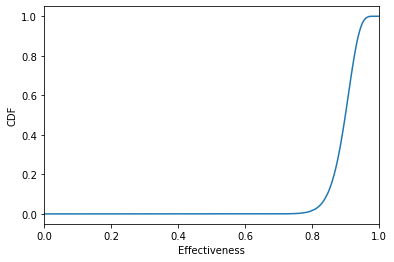

In [12]:
effectiveness.make_cdf().plot()
plt.xlim([0, 1])

plt.xlabel('Effectiveness')
plt.ylabel('CDF');

The posterior mean is about 89%.

In [13]:
effectiveness.mean()

0.8949353341973734

And the 95% credible interval is between 81% and 95%.


In [14]:
effectiveness.credible_interval(0.95)

array([0.8099631 , 0.95352564])

If my guesses about the data are close enough, and the modeling decisions are good enough, it is unlikely that the effectiveness of the vaccine is less than 80%.